<a href="https://colab.research.google.com/github/Alohadron/PyTorch-for-Deep-Learning-Bootcamp/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain librarias

Depending on what you've working on, vision, text, audio, recommendation, you'll want to look into each of PyTorch domain libraries for existing data loading functions and customizable data loading functions.

## We are going to cover

0. **Importing PyTorch and setting up device-agnostic code** -- Getting ready.
1. **Get data** -- We're going to be using our own custom dataset of pizza, steak, and sushi images.
2. **Become one with the data (data preparation)** -- At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we will take some steps to figure out what data we have.
3. **Transforming data** -- Often, tehd ata you get will not be 100% ready to use with a machine learning model, here we will look at some steps we can take to *transform* out images so they are ready to be used with a model.
4. **Loading data with `ImageFolder` (opinion 1)** -- PyTorch has many in-build data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format.
5. **Loading image data with a `Dataset`** -- What if PyTorch did not have an in-build function to load data? This is where we can build our own custom subclass of `torch.utils.data.Dataset`.
6. **Other forms of transforms (data augmentation)** -- Data augmentation is a common technique for expanding the diversity of your training data. Here we will explore some of `torchvision`'s in-build data augmentation functions.
7. **Model 0: TinyVGG without data augmentation** -- By this stage, we will have our data ready, let's build a model capable of fitting it. We will also create some training and testing functions for training and evaluating our model.
8. **Exploring loss curves** -- Loss curves are a great way to see how your model is training/improving over time. They are also a good way to see if your model is **underfitting** or **overfitting**
9. **Model 1: TinyVGG with data augmentation** -- By now, we have tried a model *without*, how about we try one *with* data augmentation?
10. **Compare model results** -- Let's compare our different models'loss curves and see which performed better and discuss some options for imporving performances.
11. **Making a prediction on a custom image** -- Our model is trained to predict on a dataset of pizza, steak, and sushi images. In this section we will cover how to use our trained model to predict on an image *outside* of our existing dataset.

## 0. Importing PyTorch and setting up device-agnostic code


In [ ]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ is required for this course
torch.__version__

'2.5.1+cu124'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset start with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why do this?

When starting ML projects, it's important to try things on a small scale and then increase the sclase when necessary.

The whole point is to speed up how fast we can experiment.

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exist... skipping downloading.")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, and sushi data
with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exist... skipping downloading.
Unzipping pizza, steak, sushi data


## 2. Become one with the data (data preparation)

Dataset downlaoded!

Time to become one with it.

This is another important step before building a model.

As Abraham Lossfunction said...

*If I had 8 hours to build a machine learning model, I'd spend the first 6 hours preparing my dataset*

Note: Become one with the data, then find a way to best turn it into a dataset compatible with PyTorch.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we will use Python's in-build `os.walk()`.

In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contest.
  Args:
    dir_path (str ot pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdirectories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in `{dirpath}`.")


In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in `data/pizza_steak_sushi`.
There are 3 directories and 0 images in `data/pizza_steak_sushi/train`.
There are 0 directories and 75 images in `data/pizza_steak_sushi/train/steak`.
There are 0 directories and 72 images in `data/pizza_steak_sushi/train/sushi`.
There are 0 directories and 78 images in `data/pizza_steak_sushi/train/pizza`.
There are 3 directories and 0 images in `data/pizza_steak_sushi/test`.
There are 0 directories and 19 images in `data/pizza_steak_sushi/test/steak`.
There are 0 directories and 31 images in `data/pizza_steak_sushi/test/sushi`.
There are 0 directories and 25 images in `data/pizza_steak_sushi/test/pizza`.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

Visualize, visualize, visualize

Let's write some code to:
1. Get all of the images paths using pathlib.Path.glob() to find all of the files ending in `.jpg`
2. Pick a random image path using Python's `random.choice()`.
3. Get the image class name using `pathlib.Path.parent.stem`.
4. And since we're working with images, we'll open the random image path using `PIL.Image.open()` (PIL stands for Python Image Library)
5. We will show the image and print some metadata.

Random image path: data/pizza_steak_sushi/train/steak/2013535.jpg
Image class: steak
Image height: 512
image width: 512


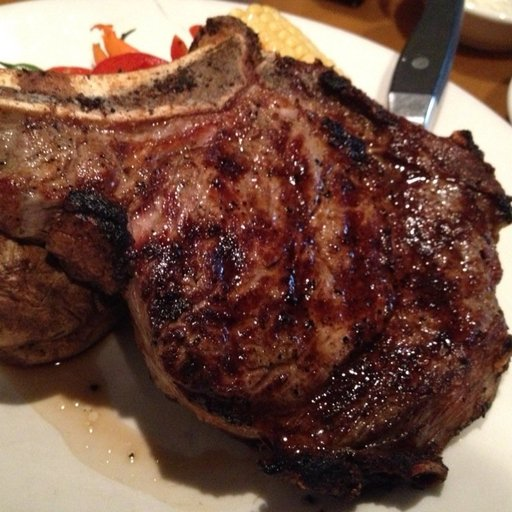

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all images paths (* means "any combinations")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"image width: {img.width}")
img

We can do the same with matplotlib.pyplot.imshow() , except we have to convert the image to a NumPy array first.

(-0.5, 511.5, 511.5, -0.5)

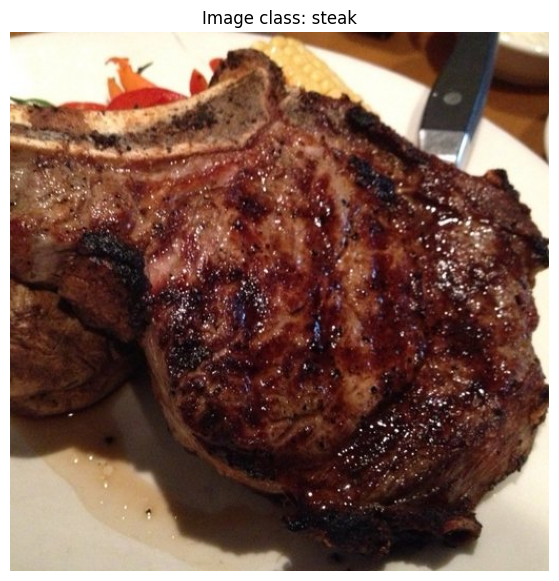

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}")
plt.axis(False)

## 3. Transforming data

Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

1. Trun it into tensors (numerical representations of the images)
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we will call these `Dataset` and `DataLoader` for short.

There are several different kinds of pre-build datasets and dataset loaders for PyTorch,
depending on the problem you are working on.

* **Vision** -- *torchvision.datasets*
* **Audio** -- *torchaudion.datasets*
* **Text** -- *torchtext.datasets*
* **Recommendation system** -- *torchrec.datasets*

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms # for preparing the data

### 3.1 Transforming data with `torchvision.transforms`

To get experience with `torchvision.tranforms`, let's write a series of transform steps that:

1. Resize the images using `transforms.Resize()` (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website)
2. Flip our images randomly on the horizontal using `transform.RandomHorizontalFlip()` (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from PIL image to a PyTorch tensor using `tranforms.ToTensor()`.

We can compile all of these steps using `torch.transforms.Compose()`.

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = propability of flip, 0.5 = 50% chance
    # turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

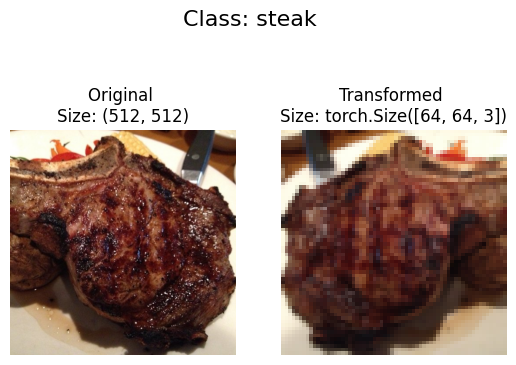

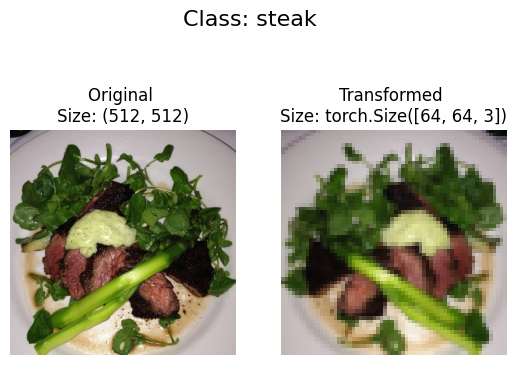

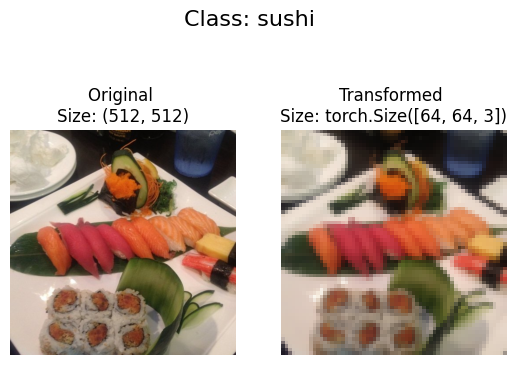

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """Plots a series of random images from image_paths.

  Will open n image paths from image_paths, transform them
  with transform and plot them side by side.

  Args:
    image_paths (list): List of target image paths.
    transform (PyTorch Transforms): Transforms to apply to images.
    n (int, optional): Number of images to plot. Default to 3.
    seed (int, optional): Random seed for random generator. Default to 42.
  """
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot the image
      # Note: premute() will change the shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)


## 4. Option 1: Loading Image Data Using `ImageFolder`

Turn image data into `Dataset` capable if being used with PyTorch.

Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`

Where we can pass it the file path of a taget image directory as well as a series of transforms we'd like to perform on our images.

Let's test it on our data folders `train_dir` and `test_dir` passing in `transform=data_transforms` to turn our images into tensors.

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if neccessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Beautiful!

It looks like PyTorch has registered our `Datasets`'s.

Let's inspect them by checking out the `classes` and `class_to_idx` attributes as well as lenghts of our training and test sets.

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check lengths
len(train_data), len(test_data)

(225, 75)

Nice! Looks like we will be able to use these to reference for later

How about our images and labels?

How do they look?

We can index on our `train_data` and `test_data` `Dataset`'s to find samples and their target labels.


In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensors:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensors:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Our images are now in the form of a tensor (with shape `[3, 64, 64]`) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute)

How about we plot a single image tensor using `matplotlib`?

We weill first have to premute (rearrange the order of it dimensions) so it's compatible.

Right now our image dimensions are in the format `CHW` (colors channels, height, width) but `matplotlib` prefers `HWC` (height, width, color channels)

Original shape: torch.Size([3, 64, 64]) - > [color channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

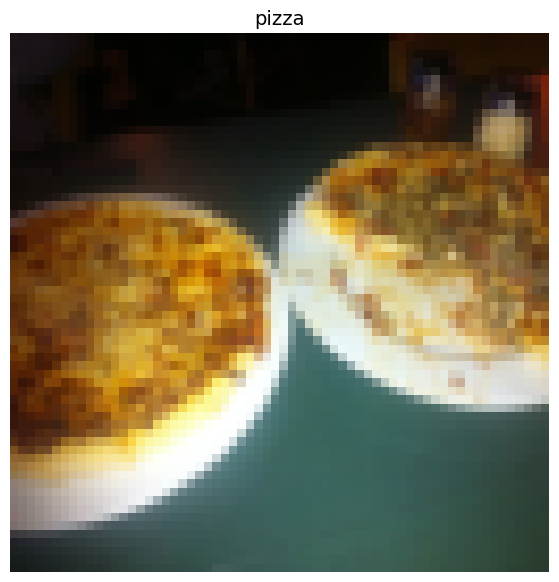

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} - > [color channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

We've got our images as PyTorch `Dataset`'s but now let's turn them into `DataLoader`'s.

To keep things simple. we will use a `batch_size=1` and `num_workers=1`

`num_workers` -- defines how many subprocesses will be created to load your data.

The higher value `num_workers` is set to, the more compute power PyTorch will use to load your data.

Usually it's the total number of CPUs on the machine via Python's `os.cpu_count()`.

This ensures the `DataLoader` recruits as many cores as possible to load data.



In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how manu subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) #  don't usually need to shuffle testing data (if True: might fuck up the confusion matrix foe example)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d9ba6568110>,
 <torch.utils.data.dataloader.DataLoader at 0x7d9ba66302d0>)

In [ ]:
# Let's try and check the shapes
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try chanching the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


We could now use these `DataLoaders` with a training and testing loop to trian a model.

But before we do, let's look at another option to load images (or almost any other kind of data)

## 5. Option 2: Loading Image Data with a Custom `Dataset`

What if pre-build `Dataset` creator like `torchvision.datasets.ImageFolder()` didn't exist?

Or one of your sprecific problem didn't exist?

Well, you could build your own?

But what are the pros and cons of creating your own custom way to load `Dataset`s?

* Pros:
1. Can create a `Dataset` out of almost anything.
2. Not limited to PyTorch pre-build `Dataset` functions.

* Cons:
1. Even though you could *create* a `Dataset` out of almost anything, it doesn't mean it will work.
2. Using a custom `Dataset` often results in writing more code, which could be prone to erros or performance issues.

To see this in action, let's work towards replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class of all `Dataset`s in PyTorch).

We will start by importing the modules we need:
* Python's `os` for dealing with directories (our data is stored in directories)
* Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath)
* `torch` for all thing PyTorch.
* PIL's `Image` class for loading images.
* `torch.utils.data.Dataset` to subclass and create our own custom `Dataset`.
* `torchvision.transforms` to turn our images into tensors.
* Various types from Python's `typing` module to add hits to our code.

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### 5.1  Creating a helper function to get class names

Let's write a helper function capable of creating a list of class names and a directory of class names and their indexes given a directory path.

To do so we will:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standart image classification format).
2. Raise an error if the class names aren't found (if this happens, there might e something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical label , one for each class (enumerate?).


In [ ]:
# Setup path to target directory
target_directory = image_path / "train"
print(f"Target directory: {target_directory}")

# 1. Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


Excellent!

How about we turn it into a full function!

In [ ]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory.

  Assumes target directory is in standard image classification format.

  Args:
    directory (str): target directory to load classname from.

  Returns:
    Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

  Example:
    find_classes("food_images/train")
    >>> (["class_1", "class_2"], {"class_1": 0, ...})
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

  # 3. Create a directory of index labels (computer prefers numerical rather than string labels)
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
# Let's test out our `find_classes()` function.

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and `transform` parameter (so we have the option to transform our data if needed).transforms
3. Create several attributes for `paths` (the paths of our target images), `transform` (the transforms we might like to use, this can be `None`), `classes` and `class_to_idx` (from out `find_classes()` function).
4. Create a function to load images from file and return them, this could be using `PIL` or `torchvision.io` (for input/output of vision data).
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so you can call `len(Dataset)`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.

LET'S DO IT!

In [ ]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. Initialize wit a tar_dir and transform (optional) parameter
  def __init__(self, targ_dir: str, transform=None) -> None:

    # 3. Create class attributes
    # Get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or jpeg's
    # Setup transforms
    self.transform = transform
    # Create class and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Make function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5 Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset.)
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset.)
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in data_folder/class_name/image.png
    class_idx = self.class_to_idx[class_name]

    # Transforms if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return data, label (X, y)

Before we test out our new `ImageFolderCustom` class, let's create some transforms to prepare our images.

In [ ]:
# Augment train data
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Now comes the moment of truth!

Let's turn out training images (contained in `train_dir`) and our testing images (contained in `test_dir`) into `Dataset`s using our own `ImageFolderCustom` class.

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d9ba656a910>,
 <__main__.ImageFolderCustom at 0x7d9ba6594d50>)

In [ ]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### 5.3 Create a function to display random images

*visualize, visualize, visualize*

Let's create a helper function called `display_random_images()` that helps us visualize images in out `Dataset`s.

Specifically, it will:

1. Take in a `Dataset` and a number of other parameters such as `classes` (the names of our target classes), the number of images to display (`n`) and a random seed.
2. To prevent the display getting out of hand, we will cap `n` at 10 images.
3. Set the random seed for reproducible plots (if `seed` is set).
4. Get a list of random samples indexes (we can use Python's `random.sample()` for this) to plot.
5. Setup a `matplotlib` plot.
6. Loop through the random sample indexes found in step 4 and plot them with `matplotlib`.
7. Make sure the sample images are of shape `HWC` so we can plot them.

In [ ]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  # 2. Adjust display if n too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n should't be larger than 10, setting to 10 and removing shape display")

  # 3. Set random seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through samples and display random samples
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust image tensor shape for plotting: [color_channels, height, width]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


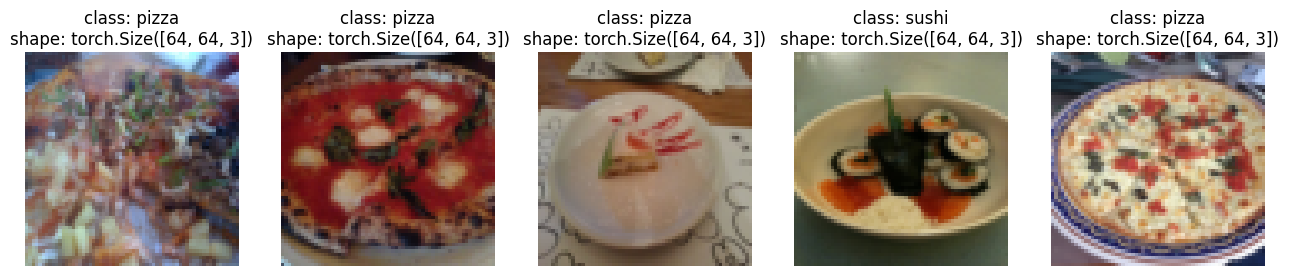

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(dataset=train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n should't be larger than 10, setting to 10 and removing shape display


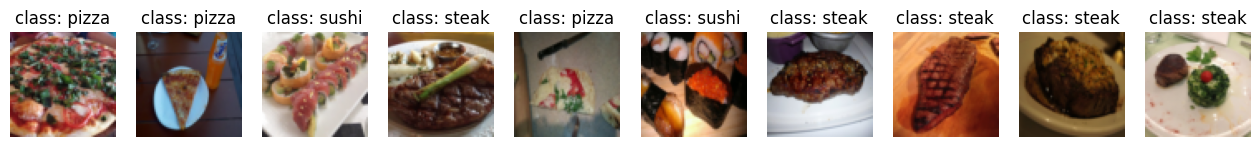

In [ ]:
# Display random images from ImageFolderCustom
display_random_images(dataset=train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `Dataloader`s

In [ ]:
# Turn train and test custom Dataset's into Dataloader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom =  DataLoader(dataset=test_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7d9ba61f0610>,
 <torch.utils.data.dataloader.DataLoader at 0x7d9ba6402e10>)

In [ ]:
# Get the image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape}")
print(f"Lable shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Lable shape: torch.Size([1])


Shapes looks good!

Let's now take a look at some other forms of data transforms.


## 6. Other forms of transforms (data augmentation).

The purpose of transforms is to alter your images in some way.

This is called **data augmentation**

**Data augmenation** is the procces of altering your data in such a way that you *artificially* increase the diversity of your training set.

Training a model on this *artificially* altered dataset hopefully results in a model that is capable of better *generalization* (the patterns it learns are more robust to future unseen examples.)

Machine Learning is all about harnessing the power of randomness and research shows that random transforms (like `transforms.RandAugment()` and `transforms.TrivialAugmentWide()` generally perform better than hand-picked transforms.)

You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitute between a given range (a higher magnitute means more instense)


In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # Use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

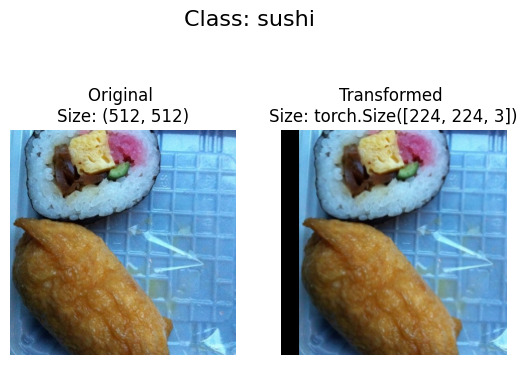

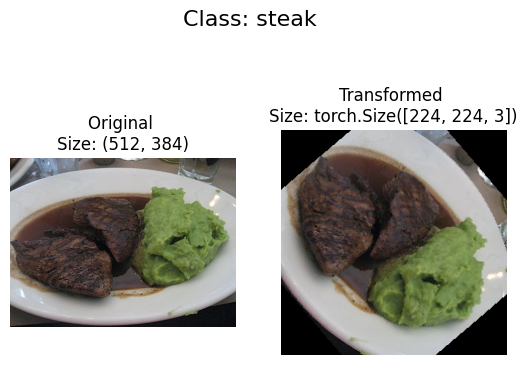

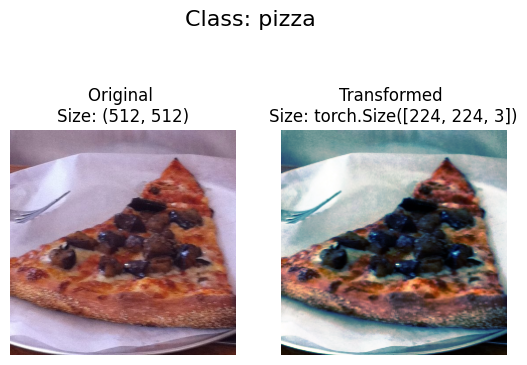

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation



### 7.1 Creating transforms and loading data for Model 0


In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Excellent, now we've got a simple transform, let's:

1. Load the data, turning each of our training and test folders first into a `Dataset` with `torchvision.datasets.ImageFolder()`
2. Then into a `DataLoader` using `torch.utils.data.DataLoader()`.
* We will set the `batch_size=32` and `num_workers` to as many as CPUs on our machine (this will depend on what machine you're using).

In [ ]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating Dataloader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create Dataloader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS)

train_data_simple, test_data_simple

Creating Dataloader's with batch size 32 and 2 workers.


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

### 7.2 Creating TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      x = self.classifier(x)
      return x

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forard pass on a single image (to test the model)

1. Get a bactch of images and labels from the `DataLoader`.
2. Get a single image from the batch and `unsqueeze()` the image so it has a batch size of `1` (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target `device`).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with `torch.softmax()` (since we are working with multi-class data) and convert the prediction probabilities to prediction labels with `torch.argmax()`.

In [ ]:
# 1. Get a bacth of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forard pass on a single image
model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))

# 4. Print out what's happening and get the predicted label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0183,  0.0506, -0.0218]])

Output prediction probabilities:
tensor([[0.3341, 0.3450, 0.3209]])

Output prediction label:
tensor([1])

Actual label:
0


So far so good!

7.4 Use `torchinfo` to get an idea of the shapes going through our model_0

A helpful method to get information from our model is to use `torchinfo`

`torchinfo` comes with a `sumary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model.input

Note: if your are using Google Colab, you will need to install `torchinfo`.


In [ ]:
# Install torchinfo if it is not available, import it if it is
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-3                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-4                       [1, 10, 32, 32]           910
│    └─ReLU: 2-5                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-8                    [1, 10, 16, 16]           --
├─Sequential: 1-3                        [1, 3]                    --
│    └─Flatten: 2-9                      [1, 2560]                 --
│    └─Linea

### 7.5 Create train & test loop function

Specifically, we are going to take three functions:
1. `train_step()` - takes in a model, a `DataLoader`, a loss fucntion and an optimizer and trains the model on the `DataLoader`.
2. `test_step()` - takes in a model, a `Dataloader` and a loss function and evaluates the model on the `DataLoader`.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put model in a train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through daa loader batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimzer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metrics across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  # Put model in evla mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop throught DataLoader batcher
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate and accumulate the loss
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = y_pred.argmax(dim=1)
      test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


### 7.6 Creating a `train()` function to combine `train_step` and `test_step()`

1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss`, and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing step for a numer of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # 4. Print out what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f} | "
    )

    # 5. Update results dictionary
    # Ensure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  # 6. Returns the filled results at the end of the epochs
  return results

### 7.7 Train and Evaluate Model 0


In [ ]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, #number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2761 | train_acc: 0.1797 | test_loss: 1.2005 | test_acc: 0.0000 | 
Epoch: 2 | train_loss: 1.1085 | train_acc: 0.3047 | test_loss: 1.1324 | test_acc: 0.0000 | 
Epoch: 3 | train_loss: 1.0944 | train_acc: 0.3047 | test_loss: 1.1001 | test_acc: 0.0000 | 
Epoch: 4 | train_loss: 1.0917 | train_acc: 0.5547 | test_loss: 1.0826 | test_acc: 0.3333 | 
Epoch: 5 | train_loss: 1.0913 | train_acc: 0.4023 | test_loss: 1.0717 | test_acc: 0.3333 | 
Total training time: 7.418 seconds


### 7.8 Plot the loss curves of Model 0

We can evaluate mododel_0'v performances by plotting the **loss curves**.

**Loss Curves** shows the model's results over time.

Let's create a function to plot values in our `model_0_results` dictionary.

In [ ]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training cuves of a results dictionary

     Args:
       results (dict): dictionary containing list of values, e.g.
       {"train_loss": [...],
        "train_acc": [...],
        "test_loss": [...],
        "test_acc": [...]}
  """

  # Get the loss values of the results dictionary (training and test)
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  train_acc = results["train_acc"]
  test_acc = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label="train_acc")
  plt.plot(epochs, test_acc, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

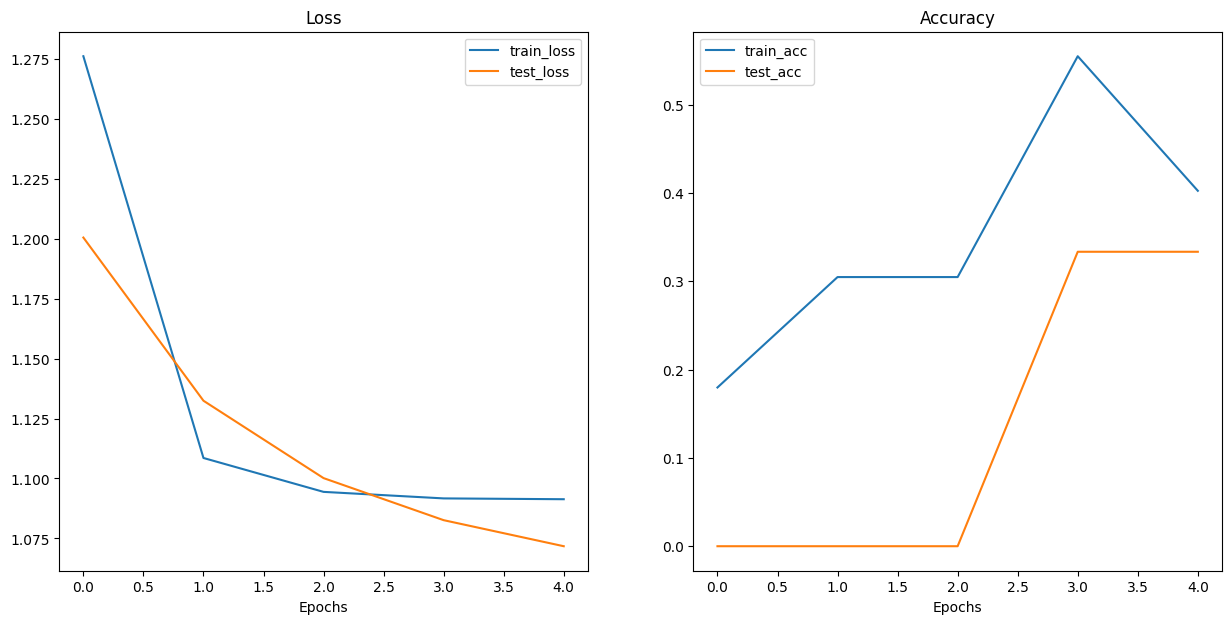

In [ ]:
plot_loss_curves(model_0_results)

## 9. Model 1: TinyVGG with Data Augmentation

This time, let's load in the data and use **data augmentation** to see if it improves our results in anyway.

First, we weill compose a training transform to include `transforms.TrivialAugmentWide()` as well as resize and turn our images into tensors.

We will do the same for a testing transform expect without the data augmentation.

### 9.1 Create transform with data augmentation.


In [ ]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


### 9.2 Create train and test `Dataset`'s and `DataLoader`'s


In [ ]:
# Turn image folder into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
# Turn Datasets into DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7d9b9ffa8150>,
 <torch.utils.data.dataloader.DataLoader at 0x7d9b9ff733d0>)

### 9.1 Construct and train Model 1

In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the time and print out how long it took
end_timer = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1071 | train_acc: 0.2500 | test_loss: 1.1005 | test_acc: 0.0000 | 
Epoch: 2 | train_loss: 1.0819 | train_acc: 0.4258 | test_loss: 1.1256 | test_acc: 0.0000 | 
Epoch: 3 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1535 | test_acc: 0.0000 | 
Epoch: 4 | train_loss: 1.1256 | train_acc: 0.3047 | test_loss: 1.1619 | test_acc: 0.0000 | 
Epoch: 5 | train_loss: 1.0869 | train_acc: 0.4258 | test_loss: 1.1552 | test_acc: 0.0000 | 
Total training time: -2992.416 seconds


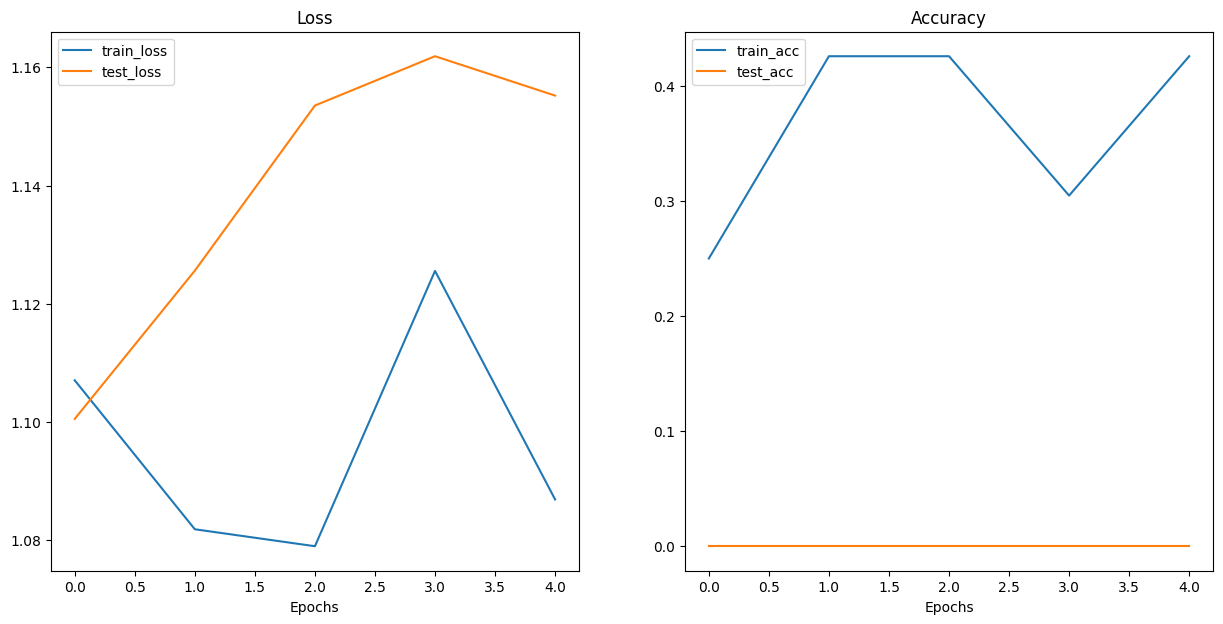

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df, model_1_df

(   train_loss  train_acc  test_loss  test_acc
 0    1.276053   0.179688   1.200451  0.000000
 1    1.108541   0.304688   1.132411  0.000000
 2    1.094409   0.304688   1.100149  0.000000
 3    1.091687   0.554688   1.082612  0.333333
 4    1.091345   0.402344   1.071749  0.333333,
    train_loss  train_acc  test_loss  test_acc
 0    1.107065   0.250000   1.100543       0.0
 1    1.081879   0.425781   1.125611       0.0
 2    1.079011   0.425781   1.153530       0.0
 3    1.125564   0.304688   1.161870       0.0
 4    1.086918   0.425781   1.155211       0.0)

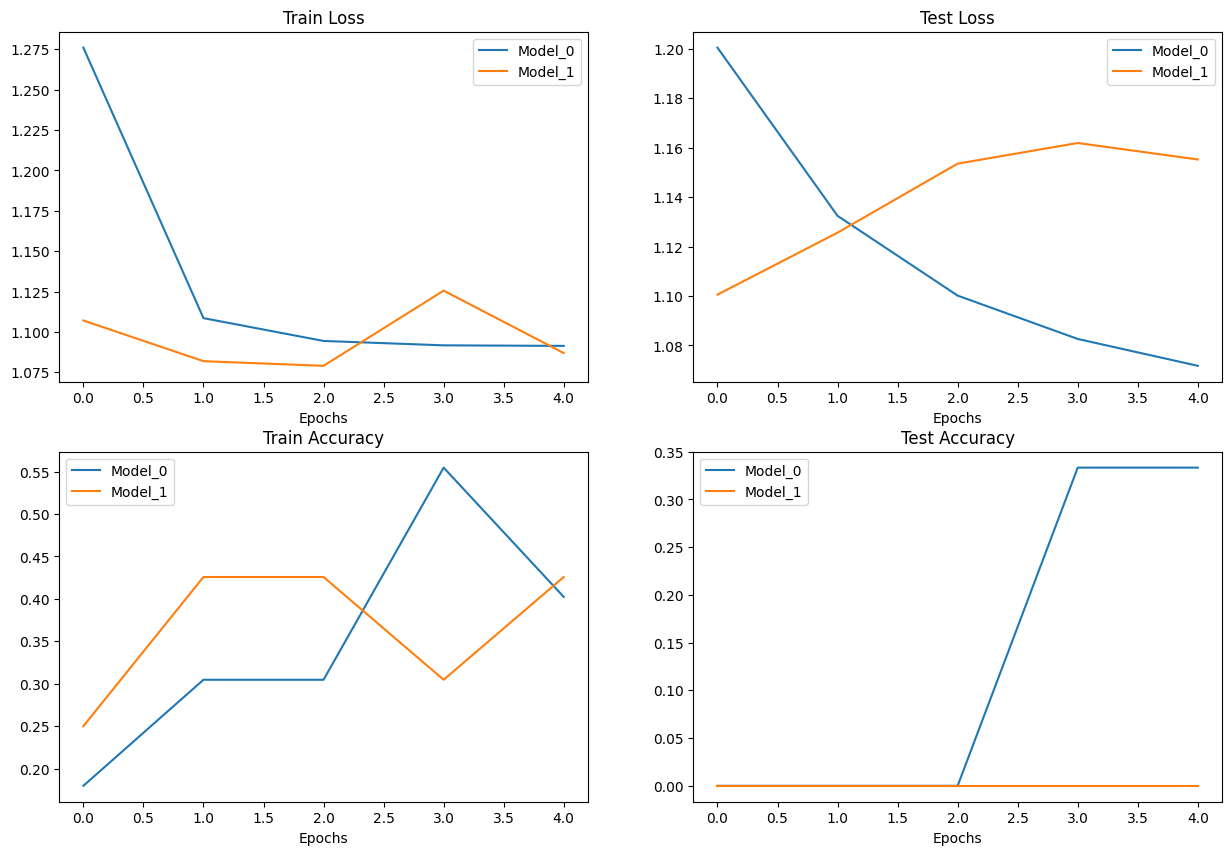

In [ ]:
# matplotlib -> visualize model_0 and model_1 results

# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model_0")
plt.plot(epochs, model_1_df["train_loss"], label="Model_1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model_0")
plt.plot(epochs, model_1_df["test_loss"], label="Model_1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model_0")
plt.plot(epochs, model_1_df["train_acc"], label="Model_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# PLot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model_0")
plt.plot(epochs, model_1_df["test_acc"], label="Model_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()